# Loan Application

This analysis looks into a dataset from a Czech bank. The goal here is to produce a model that can predict whether client should receive a loan or not.

Original [link](https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm)

From the original source, client info was divided into 8 tables:
  1. `account` - Static characteristics of the account.
  2. `client` - Describes characteristics (e.g. gender) of the client.
  3. `disposition` - Records that shows how the client is associated with the account.
  4. `permanent_order` -  Describes characteristics of the payment.
  5. `transaction` - Describes transactions for each client. It keeps track the type of payment that was made (e.g., insurance, loan payment, statement payment etc.).
  6. `loan` - Describes the loan granted for a given account.
  7. `credit_card` - Describes the credit card issued to an account.
  8. `demographic` - Describes the demographic characteristics of the client.

In the data table `loan.csv`, the data was preprocessed where the transaction data was aggregated by monthly amount.


In [0]:
! pip install shap

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376818 sha256=dcede5e5ce152635917cb3b05dc836d9edbe35565afcf0e49a28268e47abfe00
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import pandas as pd
import numpy as np

import shap

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

pd.set_option('display.max_columns', 500)


plt.rcParams['figure.facecolor'] = 'w'
sns.set()
current_palette = sns.color_palette("deep", 10)
sns.set_palette(current_palette)

# Specify the custom font to use

plt.rcParams["axes.labelweight"] = "bold"

# Save path for whatever needs to be output (USER INPUT)
save_path = ''

In [0]:
from sklearn.preprocessing   import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import classification_report

from imblearn.over_sampling  import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline       import Pipeline as imb_Pipeline


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Set directory path for the data set (USER INPUT)
file_path = ''

# Import data set
df = pd.read_csv(file_path, sep=',')

# Exploratory Data Analysis

In [0]:
df.head()

,account_id,frequency,disp_id,card_type,card_issued,order_insurance_pay,order_household_pay,order_loan_pay,order_lease_pay,district_id,district_name,region,nInhabitants,demo_avg_salary,demo_unemploy_rate95,demo_unemploy_rate96,nEnterpreneurs,nCrimes95,nCrimes96,nYearMonth,nCredit,nWithdraw,nCCWithdraw,nCreditCash,nCol_from_bank,nWithdrawCash,nRemitt,nInsurrance,nStatement,nIntCredit,nSancInt,nHousehold,nPension,nLoanPay,avgMonthly_balance,avgMonthly_amount,avgMonthly_withdrawal_card,avgMonthly_credit_cash,avgMonthly_collection_bank,avgMonthly_withdrawal_cash,avgMonthly_remittance,avgMonthly_insurance,avgMonthly_statement,avgMonthly_credited,avgMonthly_sanc_interest,avgMonthly_household,avgMonthly_pension,avgMonthly_loan,loan_id,loan_issued,loan_amount,loan_duration,loan_payments,loan_status
0,2,POPLATEK MESICNE,2,NaN,NaN,0.0,0.0,3372.7,0.0,1,Hl.m. Praha,Prague,1204953,12541,0.2,0.43,167,85677.0,99107,71,152,305,152,152,152,152,152,0,0,0,0,0,0,0,246006.9437,6725.0704,0.0,681.6901,21661.0704,14101.6479,7792.1408,0.0000,13.7324,150.9718,0.0000,6651.9718,0.0,1140.1690,4959,1994-01-05,80952,24,3373.0,A
1,19,POPLATEK MESICNE,25,NaN,NaN,0.0,0.0,2523.2,0.0,21,Tabor,south Bohemia,103347,9104,1.5,2.07,123,2299.0,2354,45,152,148,152,152,152,152,152,0,0,0,0,0,0,0,109437.3333,1672.1778,0.0,1017.7778,16484.6000,16936.7111,448.5333,0.0000,13.3333,124.2000,1.2889,10688.8889,0.0,448.5333,4961,1996-04-29,30276,12,2523.0,B
2,25,POPLATEK MESICNE,31,NaN,NaN,0.0,0.0,2523.2,0.0,68,Frydek - Mistek,north Moravia,228848,9893,4.0,4.72,96,5623.0,5887,30,82,184,82,82,82,82,82,0,0,0,0,0,0,0,514017.0333,6723.6667,0.0,49605.7333,0.0000,40514.9333,8291.1000,147.6000,13.0000,206.7667,0.0000,6135.3000,0.0,1009.2000,4962,1997-12-08,30276,12,2523.0,A
3,37,POPLATEK MESICNE,45,NaN,NaN,0.0,0.0,5307.5,0.0,20,Strakonice,south Bohemia,70646,8547,2.6,3.64,120,1563.0,1542,17,36,92,36,36,36,36,36,0,0,0,0,0,0,0,287127.8235,7600.5294,0.0,29087.8824,0.0000,22108.8235,4428.2353,79.8824,11.4706,149.1176,0.0000,1908.1176,0.0,312.2353,4967,1998-10-14,318480,60,5308.0,D
4,38,POPLATEK TYDNE,46,NaN,NaN,0.0,0.0,2306.8,0.0,19,Prachatice,south Bohemia,51428,8402,3.1,3.98,120,999.0,1099,17,48,77,48,48,48,48,48,0,0,0,0,0,0,0,263535.8824,7071.6471,0.0,2923.5294,15062.3529,9216.4118,6294.5294,160.9412,21.1765,147.4118,0.0000,4871.2941,0.0,1085.6471,4968,1998-04-19,110736,48,2307.0,C


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
account_id,682.0,5824.162757,3283.512681,2.0000,2967.000000,5738.50000,8686.000000,1.136200e+04
disp_id,682.0,7002.702346,3932.533759,2.0000,3582.250000,6941.00000,10403.000000,1.366300e+04
order_insurance_pay,682.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000e+00
order_household_pay,682.0,1081.123167,2233.438295,0.0000,0.000000,0.00000,162.500000,9.902000e+03
order_loan_pay,682.0,3352.528299,2550.658453,0.0000,0.000000,3343.10000,5270.275000,9.721000e+03
order_lease_pay,682.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000e+00
district_id,682.0,37.489736,25.184326,1.0000,13.000000,39.00000,60.000000,7.700000e+01
nInhabitants,682.0,272052.236070,358331.975172,42821.0000,92084.000000,124605.00000,226122.000000,1.204953e+06
demo_avg_salary,682.0,9502.986804,1323.150982,8110.0000,8544.000000,8991.00000,9897.000000,1.254100e+04
demo_unemploy_rate95,674.0,2.842136,1.881095,0.2000,1.500000,2.70000,3.950000,7.300000e+00


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 54 columns):
account_id                    682 non-null int64
frequency                     682 non-null object
disp_id                       682 non-null int64
card_type                     170 non-null object
card_issued                   170 non-null object
order_insurance_pay           682 non-null float64
order_household_pay           682 non-null float64
order_loan_pay                682 non-null float64
order_lease_pay               682 non-null float64
district_id                   682 non-null int64
district_name                 682 non-null object
region                        682 non-null object
nInhabitants                  682 non-null int64
demo_avg_salary               682 non-null int64
demo_unemploy_rate95          674 non-null float64
demo_unemploy_rate96          682 non-null float64
nEnterpreneurs                682 non-null int64
nCrimes95                     674 non-null fl

In [0]:
df['frequency'].unique()

array(['POPLATEK MESICNE', 'POPLATEK TYDNE', 'POPLATEK PO OBRATU'],
      dtype=object)

Map frequency in Czech to English.

In [0]:
freq_map = {'POPLATEK MESICNE': 'MONTHLY', 'POPLATEK TYDNE': 'WEEKLY', 'POPLATEK PO OBRATU': 'AFTER TRANSACTION' }

In [0]:
df['frequency'] = df['frequency'].map(freq_map)

In [0]:
df.head()

,account_id,frequency,disp_id,card_type,card_issued,order_insurance_pay,order_household_pay,order_loan_pay,order_lease_pay,district_id,district_name,region,nInhabitants,demo_avg_salary,demo_unemploy_rate95,demo_unemploy_rate96,nEnterpreneurs,nCrimes95,nCrimes96,nYearMonth,nCredit,nWithdraw,nCCWithdraw,nCreditCash,nCol_from_bank,nWithdrawCash,nRemitt,nInsurrance,nStatement,nIntCredit,nSancInt,nHousehold,nPension,nLoanPay,avgMonthly_balance,avgMonthly_amount,avgMonthly_withdrawal_card,avgMonthly_credit_cash,avgMonthly_collection_bank,avgMonthly_withdrawal_cash,avgMonthly_remittance,avgMonthly_insurance,avgMonthly_statement,avgMonthly_credited,avgMonthly_sanc_interest,avgMonthly_household,avgMonthly_pension,avgMonthly_loan,loan_id,loan_issued,loan_amount,loan_duration,loan_payments,loan_status
0,2,MONTHLY,2,NaN,NaN,0.0,0.0,3372.7,0.0,1,Hl.m. Praha,Prague,1204953,12541,0.2,0.43,167,85677.0,99107,71,152,305,152,152,152,152,152,0,0,0,0,0,0,0,246006.9437,6725.0704,0.0,681.6901,21661.0704,14101.6479,7792.1408,0.0000,13.7324,150.9718,0.0000,6651.9718,0.0,1140.1690,4959,1994-01-05,80952,24,3373.0,A
1,19,MONTHLY,25,NaN,NaN,0.0,0.0,2523.2,0.0,21,Tabor,south Bohemia,103347,9104,1.5,2.07,123,2299.0,2354,45,152,148,152,152,152,152,152,0,0,0,0,0,0,0,109437.3333,1672.1778,0.0,1017.7778,16484.6000,16936.7111,448.5333,0.0000,13.3333,124.2000,1.2889,10688.8889,0.0,448.5333,4961,1996-04-29,30276,12,2523.0,B
2,25,MONTHLY,31,NaN,NaN,0.0,0.0,2523.2,0.0,68,Frydek - Mistek,north Moravia,228848,9893,4.0,4.72,96,5623.0,5887,30,82,184,82,82,82,82,82,0,0,0,0,0,0,0,514017.0333,6723.6667,0.0,49605.7333,0.0000,40514.9333,8291.1000,147.6000,13.0000,206.7667,0.0000,6135.3000,0.0,1009.2000,4962,1997-12-08,30276,12,2523.0,A
3,37,MONTHLY,45,NaN,NaN,0.0,0.0,5307.5,0.0,20,Strakonice,south Bohemia,70646,8547,2.6,3.64,120,1563.0,1542,17,36,92,36,36,36,36,36,0,0,0,0,0,0,0,287127.8235,7600.5294,0.0,29087.8824,0.0000,22108.8235,4428.2353,79.8824,11.4706,149.1176,0.0000,1908.1176,0.0,312.2353,4967,1998-10-14,318480,60,5308.0,D
4,38,WEEKLY,46,NaN,NaN,0.0,0.0,2306.8,0.0,19,Prachatice,south Bohemia,51428,8402,3.1,3.98,120,999.0,1099,17,48,77,48,48,48,48,48,0,0,0,0,0,0,0,263535.8824,7071.6471,0.0,2923.5294,15062.3529,9216.4118,6294.5294,160.9412,21.1765,147.4118,0.0000,4871.2941,0.0,1085.6471,4968,1998-04-19,110736,48,2307.0,C


In [0]:
df['region'].unique()

array(['Prague', 'south Bohemia', 'north Moravia', 'east Bohemia',
       'north Bohemia', 'south Moravia', 'west Bohemia',
       'central Bohemia'], dtype=object)

In [0]:
df['card_type'].unique()

array([nan, 'classic', 'gold', 'junior'], dtype=object)

In [0]:
df.groupby(['loan_status'])['loan_amount'].sum()

loan_status
A    18603216
B     4362348
C    69078372
D    11217804
Name: loan_amount, dtype: int64

## Distribution of target class: `loan_status`

Text(0, 0.5, 'Count')

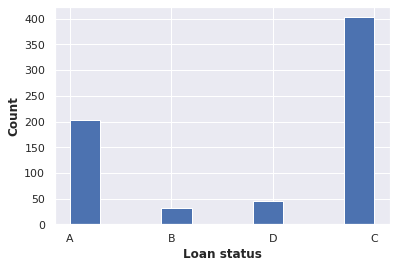

In [0]:
y = df['loan_status']
y.hist()
plt.xlabel('Loan status')
plt.ylabel('Count')

**OBSERVATIONS**: We see that those correspond to bad loan statuses (i.e., `B` and `D`) are much lower than the good loan statuses. Will first try to model without resampling and see if modeling will improve by resampling via SMOTE.

In [0]:
# Note: below are the column names for the dataframe. The ones
#       that were commented out are the ones that are omitted 
#       the analysis from a few trial-and-error.

nom_cat_var = [
           'frequency',
           #'card_type',
]

cont_var = [
            #'order_insurance_pay',
            #'order_household_pay',
            #'order_loan_pay',
            #'order_lease_pay',
            #'nInhabitants',
            #'demo_avg_salary',
            #'demo_unemploy_rate95',
            #'demo_unemploy_rate96',
            #'nEnterpreneurs',
            #'nCrimes95',
            #'nCrimes96',
            'nCredit',
            'nWithdraw',
            'nCCWithdraw', 
            'nCreditCash',
            #'nCol_from_bank', 
            'nWithdrawCash', 
            'nRemitt', 
            #'nInsurrance',
            #'nStatement', 
            #'nIntCredit', 
            'nSancInt', 
            #'nHousehold', 
            #'nPension',
            'nLoanPay',
            'avgMonthly_balance',
            #'avgMonthly_amount',
            'avgMonthly_withdrawal_card',
            #'avgMonthly_collection_bank',        
            'avgMonthly_remittance',
            #'avgMonthly_insurance',
            #'avgMonthly_statement',
            'avgMonthly_credited',
            'avgMonthly_credit_cash',
            'avgMonthly_withdrawal_cash',
            'avgMonthly_sanc_interest',
            #'avgMonthly_household',
            #'avgMonthly_pension',
            'avgMonthly_loan',
            'loan_amount',
            'loan_duration',
            'loan_payments'
]

tar_var = 'loan_status'

# Preprocessing

## Train test split

In [0]:
# Assign variables
X = df[nom_cat_var + cont_var]
y = df['loan_status']

# Then split the remaining into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

## Transforms

In [0]:
# Defining transforms

# For continuous variables
continous_transform_pipe = Pipeline(steps = [
                                        ('imputer', SimpleImputer(strategy = 'median')),
                                        #('scaler', StandardScaler())
                                  ]
                               )

# For nominal variables
nominal_transform_pipe = Pipeline(steps = [
                                      ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                                      ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [0]:
# Put everything together
# Specify to drop the remainder column 

preprocessor = ColumnTransformer(
    transformers = [
                    ('continuous', continous_transform_pipe, cont_var),
                    ('nominal', nominal_transform_pipe, nom_cat_var),
                    ],
    remainder = 'drop'
)

In [0]:
# Fitting the preprocess
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the input validation and test sets
X_test_transformed = preprocessor.transform(X_test)

In [0]:
# Transform target
target_transformer = LabelEncoder()

# Fit transformer
target_transformer.fit(y_train)

target_transformer.classes_

array(['A', 'B', 'C', 'D'], dtype=object)

In [0]:
# Transform all the target sets
y_train_transformed = target_transformer.transform(y_train)
y_test_transformed = target_transformer.transform(y_test)

# Convert transformed X back into dataframe

In [0]:
# Need to get the column names
# Start with named_transformers_
preprocessor.named_transformers_

{'continuous': Pipeline(memory=None,
          steps=[('imputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='median',
                                verbose=0))],
          verbose=False), 'nominal': Pipeline(memory=None,
          steps=[('imputer',
                  SimpleImputer(add_indicator=False, copy=True,
                                fill_value='missing', missing_values=nan,
                                strategy='constant', verbose=0)),
                 ('onehot',
                  OneHotEncoder(categorical_features=None, categories=None,
                                drop=None, dtype=<class 'numpy.float64'>,
                                handle_unknown='ignore', n_values=None,
                                sparse=True))],
          verbose=False)}

In [0]:
one_hot_columns = preprocessor.named_transformers_.nominal.named_steps.onehot.get_feature_names()

In [0]:
transformed_columns = cont_var + list(one_hot_columns)

In [0]:
X_train_transform_df = pd.DataFrame(X_train_transformed,
                                    columns = transformed_columns)

X_test_transform_df = pd.DataFrame(X_test_transformed,
                                    columns = transformed_columns)

In [0]:
X_train_transform_df.head()

,nCredit,nWithdraw,nCCWithdraw,nCreditCash,nWithdrawCash,nRemitt,nSancInt,nLoanPay,avgMonthly_balance,avgMonthly_withdrawal_card,avgMonthly_remittance,avgMonthly_credited,avgMonthly_credit_cash,avgMonthly_withdrawal_cash,avgMonthly_sanc_interest,avgMonthly_loan,loan_amount,loan_duration,loan_payments,x0_AFTER TRANSACTION,x0_MONTHLY,x0_WEEKLY
0,93.0,176.0,93.0,93.0,93.0,93.0,0.0,0.0,385266.1277,544.6809,4405.2979,256.5957,10.6383,36751.9149,0.0000,4405.2979,320592.0,48.0,6679.0,0.0,1.0,0.0
1,103.0,303.0,103.0,103.0,103.0,103.0,0.0,0.0,223005.7000,0.0000,6792.8400,105.2400,15537.9400,8352.4000,0.0000,303.8400,15192.0,24.0,633.0,0.0,1.0,0.0
2,201.0,183.0,201.0,201.0,201.0,201.0,0.0,0.0,349743.6429,0.0000,2540.0893,303.4286,39125.6429,34940.9107,0.2143,2540.0893,151728.0,48.0,3161.0,0.0,1.0,0.0
3,74.0,140.0,74.0,74.0,74.0,74.0,0.0,0.0,243228.0000,0.0000,13336.6944,131.5278,230.5556,25267.7222,0.0000,1547.2222,66840.0,24.0,2785.0,1.0,0.0,0.0
4,126.0,333.0,126.0,126.0,126.0,126.0,0.0,0.0,244903.8226,0.0000,6596.5161,138.6452,17645.0323,10670.3226,0.0000,984.7742,61056.0,48.0,1272.0,0.0,1.0,0.0


# Model 1: Random Forest (All 4 target classes)

We first try to model in model the `loan_status` of a client. Recall that this has 4 classes where A & C correspond to good loan status while B & D correspond to bad loan status.

In [0]:
rf_model1 = RandomForestClassifier(random_state = 42, n_jobs=-1)
rf_model1.fit(X_train_transform_df, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_pred1 = rf_model1.predict(X_test_transform_df)

In [0]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           A       0.76      0.76      0.76        42
           B       0.75      0.60      0.67         5
           C       0.87      0.92      0.90        79
           D       1.00      0.64      0.78        11

    accuracy                           0.84       137
   macro avg       0.85      0.73      0.78       137
weighted avg       0.84      0.84      0.84       137



**OBSERVATIONS**: With no surprise due to the imbalance set, the performance for predicting those with a bad loan status (i.e., B & D) are low compared to the good loan status predictions. 

Let us try using more optimized parameters with `RandomizedCVSearch` on the random forest classifier.

## Model 1(b): Randomized CV Search with RF model

In [0]:
cv_rf_model = RandomForestClassifier(random_state=42)

In [0]:
cv_pipeline = Pipeline(steps = [
                        ('preprocessor', preprocessor),
                        ('rf', cv_rf_model)
])

In [0]:
# Parameters for cv
cv_params = {
    'rf__n_estimators': [20, 30, 40],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1,2,4, 6]
}

In [0]:
rf_random_cv = RandomizedSearchCV(estimator = cv_pipeline,
                                  param_distributions = cv_params,
                                  n_iter = 5,
                                  random_state = 42,
                                  cv = 5,
                                  n_jobs = -1)

In [0]:
rf_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
# This is the same as gridsearch for the results.
rf_random_cv.best_score_

0.8697247706422019

In [0]:
rf_random_cv.best_params_

{'rf__bootstrap': True,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 30}

In [0]:
rf_random_cv.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('continuous',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                      

In [0]:
cv_rf_best_model1 = rf_random_cv.best_estimator_.named_steps.rf

In [0]:
y_pred1 = cv_rf_best_model1.predict(X_test_transform_df)

In [0]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           A       0.86      0.71      0.78        42
           B       0.50      0.60      0.55         5
           C       0.86      0.96      0.91        79
           D       0.88      0.64      0.74        11

    accuracy                           0.85       137
   macro avg       0.77      0.73      0.74       137
weighted avg       0.85      0.85      0.84       137



**OBSERCATIONS**: Probably the only target that showed an improvement is predicting `D`. Otherwise, not much significant improvement.

Let us now try this again but with `ADASYN` to resample the data set.

# Model 2: Randomized CV Search (Random Forest balanced class weight)

In [0]:
cv_rf_model2 = RandomForestClassifier(random_state=42)

In [0]:
cv_pipeline2 = imb_Pipeline(steps = [
                        ('preprocessor', preprocessor),
                        ('ADASYN', ADASYN(sampling_strategy='auto', random_state = 42)),
                        ('rf', cv_rf_model2)
])

In [0]:
rf_random_cv2 = RandomizedSearchCV(estimator = cv_pipeline2,
                                  param_distributions = cv_params,
                                  n_iter = 5,
                                  random_state = 42,
                                  cv = 5,
                                  n_jobs = -1)

In [0]:
rf_random_cv2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
# This is the same as gridsearch for the results.
rf_random_cv2.best_score_

0.8807339449541285

In [0]:
cv_rf_best_model2 = rf_random_cv2.best_estimator_.named_steps.rf

In [0]:
cv_rf_best_model2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_pred2 = cv_rf_best_model2.predict(X_test_transform_df)

In [0]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           A       0.89      0.74      0.81        42
           B       0.62      1.00      0.77         5
           C       0.89      0.95      0.92        79
           D       0.90      0.82      0.86        11

    accuracy                           0.88       137
   macro avg       0.83      0.88      0.84       137
weighted avg       0.88      0.88      0.87       137



# Model 3: Group target variables into Loan Accept and Reject

Create new target class called `loan_rejected` where if the `loan_status` of the client is B or D then it is `True` otherwise, it is `False`.

In [0]:
df['loan_rejected'] = df['loan_status'].apply(lambda x: True if (x== 'B' or x == 'D') else False)
y_new = df['loan_rejected']

In [0]:
y_new.value_counts()

False    606
True      76
Name: loan_rejected, dtype: int64

**NOTE**: This confirms that there are 606 approved loans as mentioned in the project brief (Note to self: this should've been the first thing to check in the EDA lol).

Because the target classes are re-grouped. We need to redo the train-split.

In [0]:
# Assign X
X = df[nom_cat_var + cont_var]

# Then split the remaining into training and validation sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y_new, random_state = 42, test_size = 0.2)

In [0]:
# Fitting the preprocess
X_train_transformed3 = preprocessor.fit_transform(X_train3)

# Transform the input validation and test sets
X_test_transformed3 = preprocessor.transform(X_test3)

In [0]:
X_train_transform_df3 = pd.DataFrame(X_train_transformed3,
                                    columns = transformed_columns)

X_test_transform_df3 = pd.DataFrame(X_test_transformed3,
                                    columns = transformed_columns)

In [0]:
cv_rf_model3 = RandomForestClassifier(random_state=42, 
                                      class_weight = 'balanced'
                                      )

In [0]:
cv_pipeline3 = imb_Pipeline(steps = [
                        ('preprocessor', preprocessor),
                        ('rf', cv_rf_model3)
])

In [0]:
# Parameters for cv
cv_params = {
    'rf__n_estimators': [30, 40, 50],
    'rf__bootstrap': [True, False],
    'rf__min_samples_split': [5, 10, 15],
    'rf__min_samples_leaf': [1, 2, 4]
}


In [0]:
rf_random_cv3 = RandomizedSearchCV(estimator = cv_pipeline3,
                                  param_distributions = cv_params,
                                  n_iter = 5,
                                  random_state = 42, 
                                  scoring = 'precision',
                                  cv = 5,
                                  n_jobs = -1)

In [0]:
rf_random_cv3.fit(X_train3, y_train3)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('continuous',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                              

In [0]:
# This is the same as gridsearch for the results.
rf_random_cv3.best_score_

0.9436363636363636

In [0]:
rf_random_cv3.best_params_

{'rf__bootstrap': True,
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 40}

In [0]:
rf_model3 = rf_random_cv3.best_estimator_.named_steps.rf

In [0]:
rf_model3.fit(X_train_transform_df3, y_train3)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
y_pred3 = rf_model3.predict(X_test_transform_df3)

In [0]:
print(classification_report(y_test3, y_pred3))

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       121
        True       0.78      0.88      0.82        16

    accuracy                           0.96       137
   macro avg       0.88      0.92      0.90       137
weighted avg       0.96      0.96      0.96       137



**OBSERVATIONS**: Significant improvement on classifying rejected loan applicants by re-grouping the target classes and resampling them with `ADASYN`.



## Further optimize with GridSearchCV 

In [0]:
gridcv_pipe = imb_Pipeline(steps = [
                        ('preprocessor', preprocessor),
                        ('rf', RandomForestClassifier(random_state = 42, class_weight = 'balanced'))
                        ]
                         )

In [0]:
# Parameters for gridcv
gridcv_params = {
    'rf__n_estimators': [30, 40, 50],
    'rf__bootstrap': [False],
    'rf__min_samples_split': [10,11],
    'rf__min_samples_leaf': [2,3]
}

In [0]:
grid_cv_1 = GridSearchCV(gridcv_pipe, gridcv_params, scoring = 'precision', cv = 5, n_jobs= -1)
grid_cv_1.fit(X_train3, y_train3)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('continuous',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
             

In [0]:
best_params_final = grid_cv_1.best_params_
print(best_params_final)

{'rf__bootstrap': False, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 10, 'rf__n_estimators': 40}


In [0]:
grid_cv_1.best_score_

0.9464335664335664

In [0]:
rf_model_final = grid_cv_1.best_estimator_.named_steps.rf

In [0]:
rf_model_final.fit(X_train_transform_df3, y_train3)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [0]:
y_pred_test3 = rf_model_final.predict(X_test_transform_df3)

In [0]:
print(classification_report(y_test3, y_pred_test3))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98       121
        True       0.82      0.88      0.85        16

    accuracy                           0.96       137
   macro avg       0.90      0.93      0.91       137
weighted avg       0.96      0.96      0.96       137



In [0]:
y_pred_train3 = rf_model_final.predict(X_train_transform_df3)

In [0]:
print(classification_report(y_train3, y_pred_train3))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00       485
        True       0.95      1.00      0.98        60

    accuracy                           0.99       545
   macro avg       0.98      1.00      0.99       545
weighted avg       0.99      0.99      0.99       545



# SHAP analysis

In [0]:
explainer = shap.TreeExplainer(rf_model_final)

shap_values = explainer.shap_values(X_train_transform_df3)

In [0]:
# Initialize JavaScript
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],feature_names = transformed_columns)

In [0]:
# Initialize JavaScript
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][30],
                features = X_train_transform_df3.iloc[30,:].values,
                feature_names = transformed_columns)

In [0]:
# Initialize JavaScript
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][30],
                features = X_train_transform_df3.iloc[30,:].values,
                feature_names = transformed_columns)

In [0]:
# Initialize JavaScript
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][10],
                features = X_train_transform_df3.iloc[10,:].values,
                feature_names = transformed_columns,
                )

In [0]:
rf_model_final.predict(X_train_transform_df3.iloc[10,:].values.reshape(1,-1))

array([ True])

In [0]:
rf_model_final.predict_proba(X_train_transform_df3.iloc[10,:].values.reshape(1,-1))

array([[0.01293091, 0.98706909]])

We now know that the 2 items in `shap_values` are:

  1. 0 - Loan not rejected.
  2. 1 - Loan rejected.


In [0]:
type(shap_values)

list

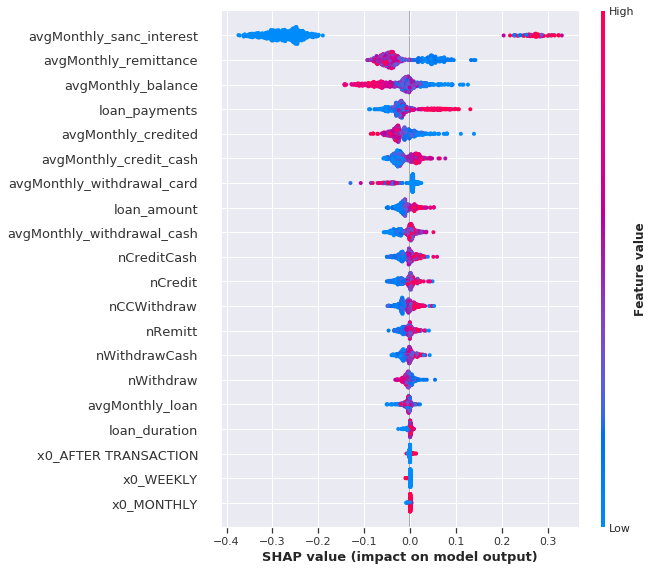

In [0]:
shap.initjs()
fig = shap.summary_plot(shap_values[1],
                  features = X_train_transform_df3,
                  feature_names = transformed_columns, 
                  )

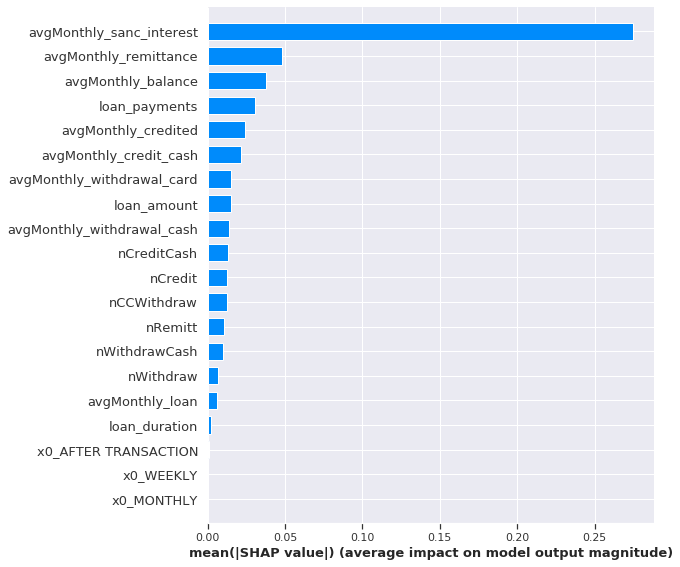

In [0]:
# This shows the mean magnitude of shap values for each variable
shap.summary_plot(shap_values[1], X_train_transform_df3, plot_type = 'bar',)

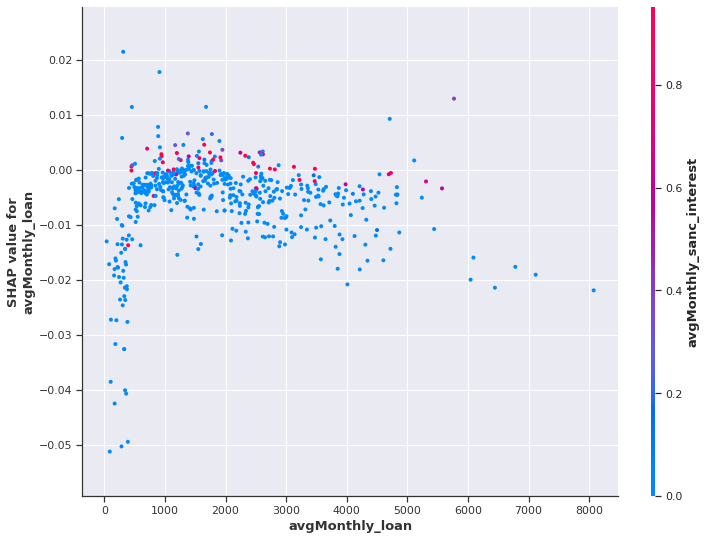

In [0]:
fig, ax = plt.subplots(figsize = (12, 9))
fig = shap.dependence_plot('avgMonthly_loan', 
                     shap_values[1], 
                     X_train_transform_df3,
                     feature_names=transformed_columns,
                     interaction_index = 'avgMonthly_sanc_interest',
                     show = False,
                     ax = ax
                     )

# SHAP analysis (Reduced columns)

In [0]:
X_train_transform_df3.iloc[:,9:18].head()

,avgMonthly_withdrawal_card,avgMonthly_remittance,avgMonthly_credited,avgMonthly_credit_cash,avgMonthly_withdrawal_cash,avgMonthly_sanc_interest,avgMonthly_loan,loan_amount,loan_duration
0,544.6809,4405.2979,256.5957,10.6383,36751.9149,0.0000,4405.2979,320592.0,48.0
1,0.0000,6792.8400,105.2400,15537.9400,8352.4000,0.0000,303.8400,15192.0,24.0
2,0.0000,2540.0893,303.4286,39125.6429,34940.9107,0.2143,2540.0893,151728.0,48.0
3,0.0000,13336.6944,131.5278,230.5556,25267.7222,0.0000,1547.2222,66840.0,24.0
4,0.0000,6596.5161,138.6452,17645.0323,10670.3226,0.0000,984.7742,61056.0,48.0


In [0]:
condensed_cols = ['avgMonthly_withdrawal_card',	
                  'avgMonthly_remittance',
                   'avgMonthly_credited',
                  'avgMonthly_credit_cash',
                  'avgMonthly_withdrawal_cash',
                  'avgMonthly_sanc_interest', 
                  'avgMonthly_loan',
                  'loan_amount', 
                  'loan_duration']

renamed_cols = ['Avg. Monthly Withdrawal by Credit Card',	
                'Avg. Monthly Remittance',
                'Avg. Monthly Credited',
                'Avg. Monthly Credited by Cash',
                'Avg. Monthly Withdrawal by Cash',
                'Avg. Monthly Default Interest',
                'Avg. Monthly Loan Payment',
                'Total Loan Amount',
                'Total Loan Duration'
                ]
X_condensed_df = X_train_transform_df3.iloc[:,9:18]
X_condensed_df.columns =renamed_cols

In [0]:
X_condensed_df.head()

,Avg. Monthly Withdrawal by Credit Card,Avg. Monthly Remittance,Avg. Monthly Credited,Avg. Monthly Credited by Cash,Avg. Monthly Withdrawal by Cash,Avg. Monthly Default Interest,Avg. Monthly Loan Payment,Total Loan Amount,Total Loan Duration
0,544.6809,4405.2979,256.5957,10.6383,36751.9149,0.0000,4405.2979,320592.0,48.0
1,0.0000,6792.8400,105.2400,15537.9400,8352.4000,0.0000,303.8400,15192.0,24.0
2,0.0000,2540.0893,303.4286,39125.6429,34940.9107,0.2143,2540.0893,151728.0,48.0
3,0.0000,13336.6944,131.5278,230.5556,25267.7222,0.0000,1547.2222,66840.0,24.0
4,0.0000,6596.5161,138.6452,17645.0323,10670.3226,0.0000,984.7742,61056.0,48.0


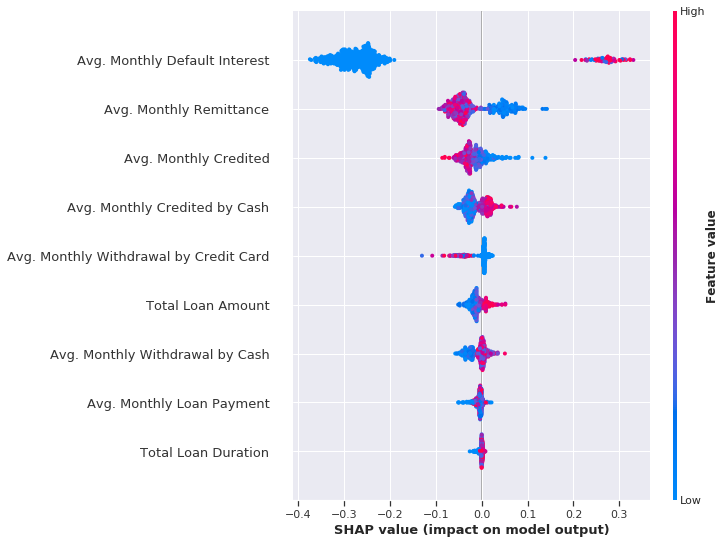

In [0]:
shap.initjs()
plt.figure(figsize=(11,10))
fig = shap.summary_plot(shap_values[1][:,9:18],
                  features = X_condensed_df,
                  feature_names = renamed_cols, 
                  show = False, 
                  plot_size = (8, 9)
                  )

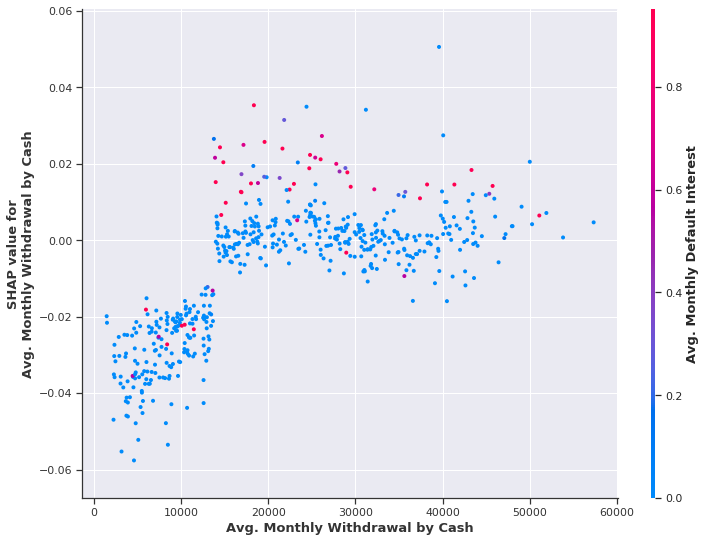

In [0]:
# This shows the mean magnitude or shap values for each variable.
fig, ax = plt.subplots(figsize = (12, 9))
fig = shap.dependence_plot('Avg. Monthly Withdrawal by Cash', 
                     shap_values[1][:,9:18], 
                     X_condensed_df,
                     feature_names=renamed_cols,
                     interaction_index = 'Avg. Monthly Default Interest',
                     ax = ax
                     )

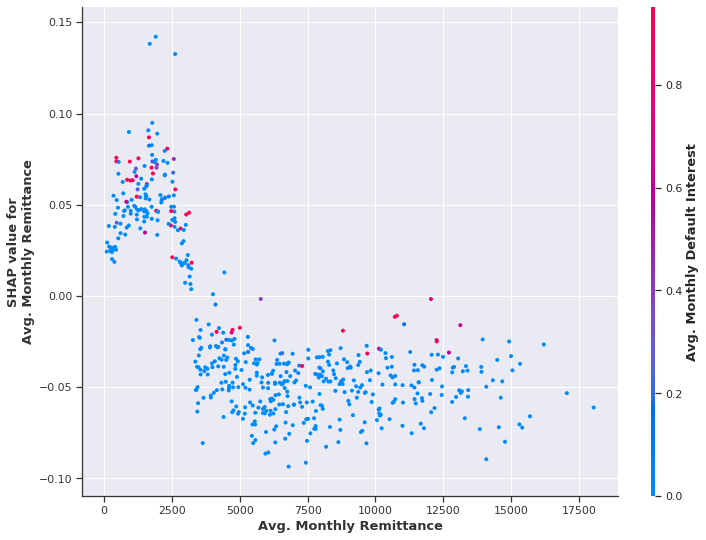

In [0]:
# This shows the mean magnitude or shap values for each variable.
fig, ax = plt.subplots(figsize = (12, 9))
fig = shap.dependence_plot('Avg. Monthly Remittance', 
                     shap_values[1][:,9:18], 
                     X_condensed_df,
                     feature_names=renamed_cols,
                     interaction_index = 'Avg. Monthly Default Interest',
                     show = False,
                     ax = ax
                     )

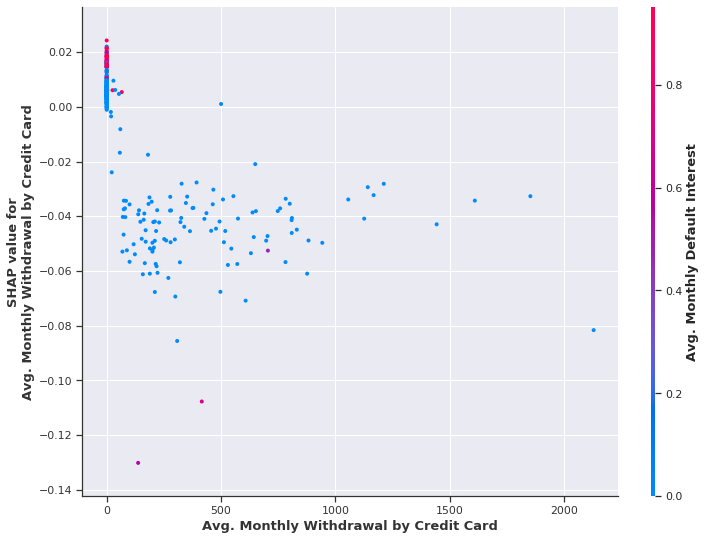

In [0]:
# This shows the mean magnitude or shap values for each variable.
fig, ax = plt.subplots(figsize = (12, 9))

shap.dependence_plot('Avg. Monthly Withdrawal by Credit Card', 
                     shap_values[1][:,9:18], 
                     X_condensed_df,
                     feature_names=renamed_cols,
                     interaction_index = 'Avg. Monthly Default Interest', 
                     show = False,
                     ax = ax
                     )

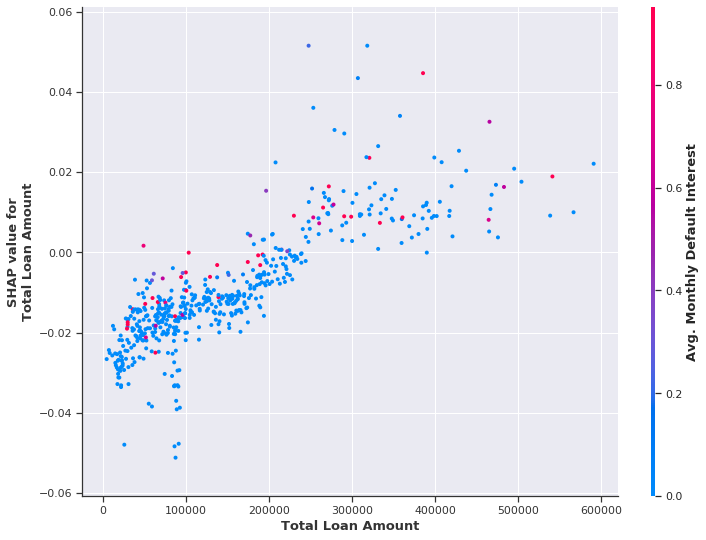

In [0]:
fig, ax = plt.subplots(figsize = (12, 9))

shap.dependence_plot('Total Loan Amount', 
                     shap_values[1][:,9:18], 
                     X_condensed_df,
                     feature_names=renamed_cols,
                     interaction_index = 'Avg. Monthly Default Interest', 
                     show = False,
                     ax = ax
                     )